In [4]:
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [2]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import HTML, Markdown, display
from functools import reduce

MEASUREMENTS_FOLDER = "Variance logs"

setting_names = set(
    [
        "texture size",
        "downscale",
        "number of clusters",
        "number of iterations",
        "randomize empty clusters",
        "staggered jitter",
        "jitter size",
        "video file",
        "algorithm",
    ]
)

def load_measurements(measurement_name: str):
    log_file_names = os.listdir(f"{MEASUREMENTS_FOLDER}/{measurement_name}")
    
    def setting_transform(value):
        match value:
            case "True":
                return "Yes"
            case "False":
                return "No"
        return value
    
    measurements = [
        {
            "settings" : {
                setting_name : setting_transform(setting_value)
                    for setting_name, setting_value in [
                            setting_text.split(":")
                                for setting_text in ".".join(file_name.split(".")[:-1]).split("|")
                        ]
            },
            "variance" : pd.read_csv(
                f"{MEASUREMENTS_FOLDER}/{measurement_name}/{file_name}"
            )["Variance"].tolist()[10:-10], # first and lust 10 frames removed
            "file name" : file_name
        }
        for file_name in log_file_names
    ]
    
    for measurement in measurements:
        assert (
            set(
                measurement["settings"].keys()
            ) == set(
                setting_names
            )
        )
    
    for measurement in measurements:
        measurement["total variance"] = sum(measurement["variance"]) / len(measurement["variance"])
    
    for measurement in measurements:
        measurement["peak variance"] = max(measurement["variance"])
    
    return measurements

def show_measurements_table(measurements):    
    def get_setting_value_lengths(measurements):
        return {
            setting_name : max(
                max(
                    [
                        len(measurement["settings"][setting_name])
                            for measurement in measurements
                    ]
                ),
                len(setting_name)
            )
            for setting_name in setting_names
        }
    
    def get_settings_same_everywhere(measurements):
        def is_setting_same_everywhere(setting_name):
            for measurement in measurements:
                if measurement["settings"][setting_name] != measurements[0]["settings"][setting_name]:
                    return False
            return True
        return [setting_name for setting_name in setting_names if is_setting_same_everywhere(setting_name)]
    
    setting_value_lengths = get_setting_value_lengths(measurements)
    settings_same_everywhere = get_settings_same_everywhere(measurements)
    
    def print_setting(name, value):
        print(value, end="")
        print(
            " " * (
                setting_value_lengths[name] - len(value)
            ),
            end=""
        )


    for setting_name in setting_names:
        if setting_name in settings_same_everywhere:
            continue
        print(setting_name, end="")
        print("  |  ", end="")
    print("variance")
    print("-" *
        (
            sum(
                [
                    setting_value_lengths[name] + 5
                    for name in setting_names
                    if not name in settings_same_everywhere
                ]
            ) + 8
        )
    )

    for measurement in measurements:
        for setting_name in setting_names:
            if setting_name in settings_same_everywhere:
                continue
            print_setting(setting_name, measurement["settings"][setting_name])
            print("  |  ", end="")
        total_variance_string = f"{measurement['total variance']:0.5f}"
        print(f"{total_variance_string:10}", end="")
        print()

def init_seaborn():
    sb.set(
        font_scale=1.2,
        rc={
            "figure.figsize":(14, 6)
        },
        palette="deep"
    )

init_seaborn()

In [4]:
display(Markdown("# ToDo measurements"))

display(
    Markdown(
"""
|Measurement|Clusters|Iterations|Texture size|
|----|----|----|----|
|subsampling|🗸|-|🗸|
|downscaling|-|-|🗸|
|jitter|-|-|🗸|
|scanline jitter|-|-|🗸|
|randomize vs freeze empty clusters|-|-|🗸|
|local mimimum check|🗸|-|-|

* Random swap
    * randomize 1 cluster
    * full randomization
    * simple K-Means
* KHM and random swap
    * KM
    * KHM
    * KM + random swap

----

In order to show, that KM does not get stuck in local minimum:

* 12 iterations of KM
* 6 iterations of random swap
* 12 iterations of KHM

**plot Variance and peak variance**

-----

Use random swap only as a reference to check for local minimum. KHM is clearly superior,
because it does not require additional dispatches and texture reads.

But do make performance benchmarks to show this, and show that KHM achieves similar quality to random swap.
"""
    )
)

# ToDo measurements


|Measurement|Clusters|Iterations|Texture size|
|----|----|----|----|
|subsampling|🗸|-|🗸|
|downscaling|-|-|🗸|
|jitter|-|-|🗸|
|scanline jitter|-|-|🗸|
|randomize vs freeze empty clusters|-|-|🗸|
|local mimimum check|🗸|-|-|

* Random swap
    * randomize 1 cluster
    * full randomization
    * simple K-Means
* KHM and random swap
    * KM
    * KHM
    * KM + random swap

----

In order to show, that KM does not get stuck in local minimum:

* 12 iterations of KM
* 6 iterations of random swap
* 12 iterations of KHM

**plot Variance and peak variance**

-----

Use random swap only as a reference to check for local minimum. KHM is clearly superior,
because it does not require additional dispatches and texture reads.

But do make performance benchmarks to show this, and show that KHM achieves similar quality to random swap.


In [5]:
display(Markdown("# Dataset 1: subsampling"))

M1 = load_measurements("1. subsampling")

M1 = sorted(
    M1,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
    )
)


show_measurements_table(M1)

# Dataset 1: subsampling

number of clusters  |  video file  |  texture size  |  variance
---------------------------------------------------------------
4                   |  1           |  512           |  0.01443   
6                   |  1           |  512           |  0.00765   
8                   |  1           |  512           |  0.00496   
12                  |  1           |  512           |  0.00243   
16                  |  1           |  512           |  0.00151   
4                   |  1           |  256           |  0.01443   
6                   |  1           |  256           |  0.00766   
8                   |  1           |  256           |  0.00496   
12                  |  1           |  256           |  0.00244   
16                  |  1           |  256           |  0.00152   
4                   |  1           |  128           |  0.01443   
6                   |  1           |  128           |  0.00765   
8                   |  1           |  128           |  0.00497   
16            

## Plots

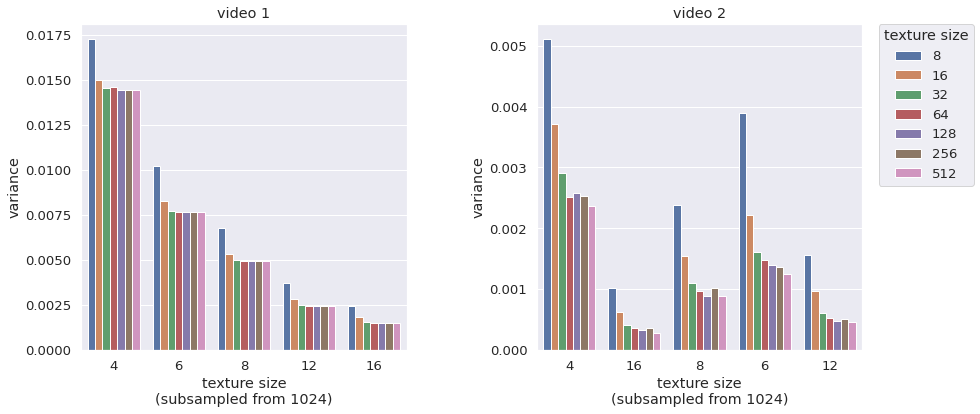

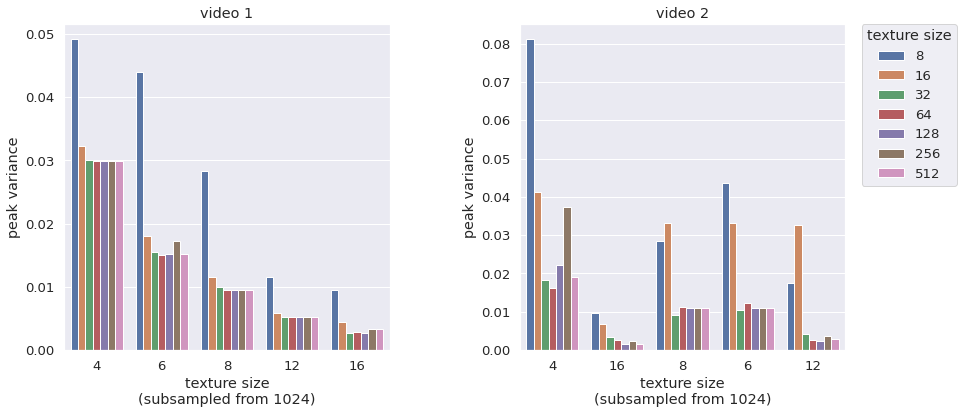

In [6]:
display(Markdown("## Plots"))

def subsample_variance_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement["settings"]["texture size"]),
                    measurement["total variance"],
                    measurement["settings"]["number of clusters"],
                )
                    for measurement in M1
                        if measurement["settings"]["video file"] == video_name
            ],
            columns=["texture size", "total variance", "number of clusters"]
        )



    total_variance_by_texture_size = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        x=total_variance_by_texture_size["video 1"]["number of clusters"],
        y=total_variance_by_texture_size["video 1"]["total variance"],
        ax=axes[0],
        hue=total_variance_by_texture_size["video 1"]["texture size"],
        ci=None,
    )
    
    g.legend().remove()

    axes[0].set_ylabel("variance")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    g = sb.barplot(
        x=total_variance_by_texture_size["video 2"]["number of clusters"],
        y=total_variance_by_texture_size["video 2"]["total variance"],
        ax=axes[1],
        hue=total_variance_by_texture_size["video 2"]["texture size"],
        ci=None,
    )

    axes[1].set_ylabel("variance")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")
    
    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0,
        title="texture size"
    )

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()
    
def subsample_peak_variance_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement["settings"]["texture size"]),
                    measurement["total variance"],
                    measurement["peak variance"],
                    measurement["settings"]["number of clusters"],
                )
                    for measurement in M1
                        if measurement["settings"]["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "number of clusters"]
        )



    data = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        x=data["video 1"]["number of clusters"],
        y=data["video 1"]["peak variance"],
        ax=axes[0],
        hue=data["video 1"]["texture size"],
        ci=None,
    )
    
    g.legend().remove()

    axes[0].set_ylabel("peak variance")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    g = sb.barplot(
        x=data["video 2"]["number of clusters"],
        y=data["video 2"]["peak variance"],
        ax=axes[1],
        hue=data["video 2"]["texture size"],
        ci=None,
    )

    axes[1].set_ylabel("peak variance")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")
    
    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0,
        title="texture size"
    )

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()
    
subsample_variance_plots()
subsample_peak_variance_plots()

In [7]:
display(Markdown("# Dataset 2: scaling vs subsampling"))

M2 = load_measurements("2. scaling vs subsampling")

M2 = sorted(
    M2,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["downscale"],
    )
)


show_measurements_table(M2)

# Dataset 2: scaling vs subsampling

downscale  |  video file  |  texture size  |  variance
------------------------------------------------------
No         |  1           |  512           |  0.00765   
Yes        |  1           |  512           |  0.00765   
No         |  1           |  256           |  0.00766   
Yes        |  1           |  256           |  0.00773   
No         |  1           |  128           |  0.00765   
Yes        |  1           |  128           |  0.00765   
No         |  1           |  64            |  0.00764   
Yes        |  1           |  64            |  0.00766   
No         |  1           |  32            |  0.00772   
Yes        |  1           |  32            |  0.00783   
No         |  1           |  16            |  0.00827   
Yes        |  1           |  16            |  0.00809   
No         |  1           |  8             |  0.01019   
Yes        |  1           |  8             |  0.00966   
No         |  2           |  512           |  0.00125   
Yes        |  2           |  512   

## Plots

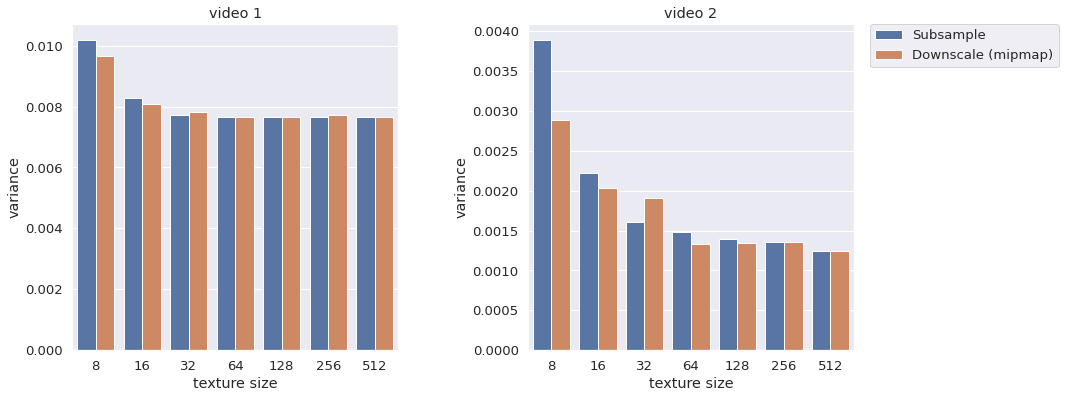

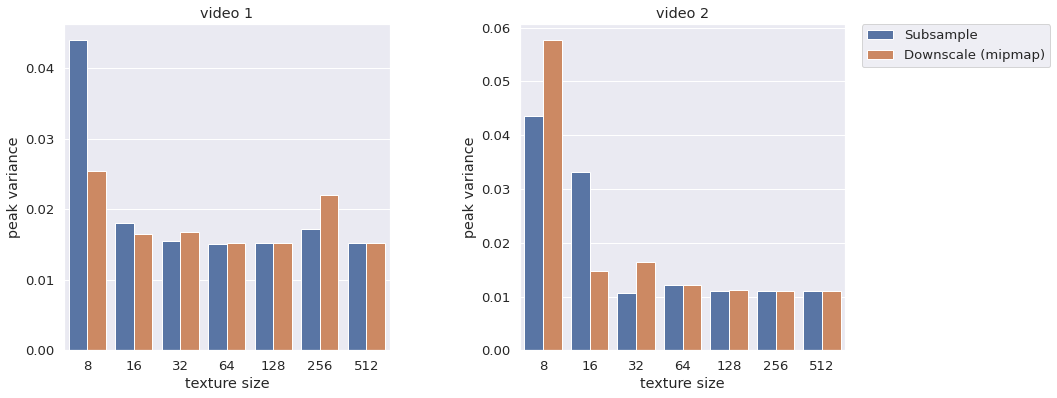

In [8]:
display(Markdown("## Plots"))

def subsample_vs_downscale_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    measurement["total variance"],
                    measurement["peak variance"],
                    int(measurement["settings"]["texture size"]),
                    
                    "Downscale (mipmap)"
                            if measurement["settings"]["downscale"] == "Yes"
                    else "Subsample"     
                )
                    for measurement in M2
                        if measurement["settings"]["video file"] == video_name
            ],
            columns=["total variance", "peak variance", "texture size", "downscale"]
        )

    data_frames = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames["video 1"],
            x="texture size",
            y="total variance",
            hue="downscale",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames["video 2"],
            x="texture size",
            y="total variance",
            hue="downscale",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
        )
        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames["video 1"],
            x="texture size",
            y="peak variance",
            hue="downscale",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames["video 2"],
            x="texture size",
            y="peak variance",
            hue="downscale",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
        )
        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    plot_variance()
    plot_peak_variance()

subsample_vs_downscale_plots()

In [9]:
display(Markdown("## Jitter"))

## Jitter

In [10]:
display(Markdown("## Dataset 3: staggered jitter"))

M3 = load_measurements("3. staggered jitter")

M3 = sorted(
    M3,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["jitter size"],
    )
)


show_measurements_table(M3)

## Dataset 3: staggered jitter

jitter size  |  video file  |  texture size  |  variance
--------------------------------------------------------
1            |  1           |  64            |  0.00764   
1            |  1           |  32            |  0.00772   
2            |  1           |  32            |  0.00774   
1            |  1           |  16            |  0.00827   
2            |  1           |  16            |  0.00832   
4            |  1           |  16            |  0.00812   
1            |  1           |  8             |  0.01019   
2            |  1           |  8             |  0.01012   
4            |  1           |  8             |  0.00982   
8            |  1           |  8             |  0.00970   
1            |  1           |  4             |  0.01538   
16           |  1           |  4             |  0.01450   
2            |  1           |  4             |  0.01513   
4            |  1           |  4             |  0.01496   
8            |  1           |  4             |  0.01500   
1

In [9]:
display(Markdown("## Dataset 4: scanline jitter"))

M4 = load_measurements("4. scanline jitter")

M4 = sorted(
    M4,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["jitter size"],
    )
)

show_measurements_table(M4)

## Dataset 4: scanline jitter

texture size  |  video file  |  jitter size  |  variance
--------------------------------------------------------
64            |  1           |  1            |  0.00764   
32            |  1           |  1            |  0.00772   
32            |  1           |  2            |  0.00772   
16            |  1           |  1            |  0.00827   
16            |  1           |  2            |  0.00814   
16            |  1           |  4            |  0.00815   
8             |  1           |  1            |  0.01019   
8             |  1           |  2            |  0.01004   
8             |  1           |  4            |  0.00994   
8             |  1           |  8            |  0.01005   
4             |  1           |  1            |  0.01538   
4             |  1           |  16           |  0.01518   
4             |  1           |  2            |  0.01507   
4             |  1           |  4            |  0.01554   
4             |  1           |  8            |  0.01532   
6

### Plots

#### Staggered jitter

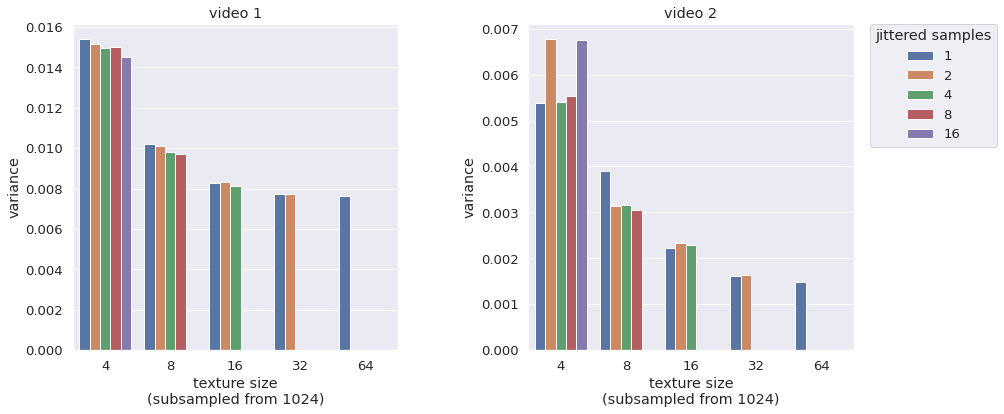

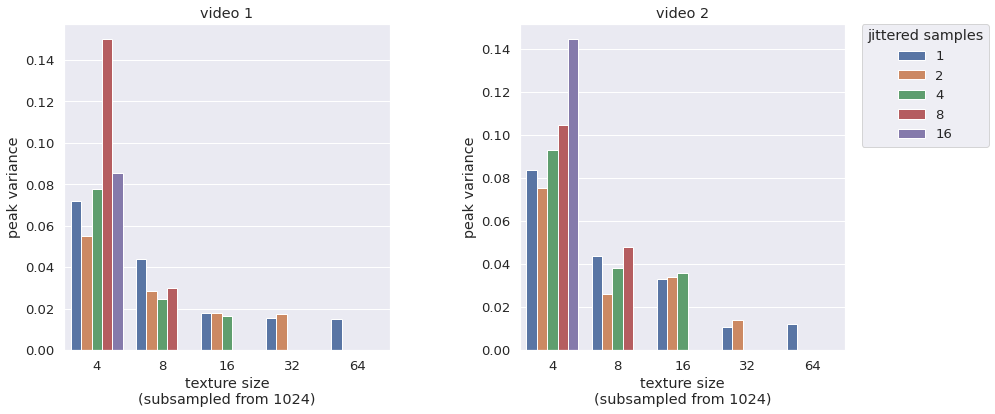

#### Scanline jitter

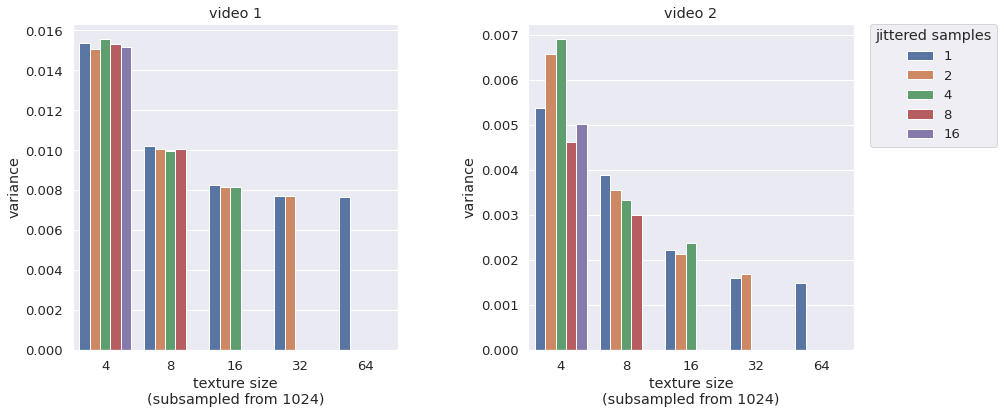

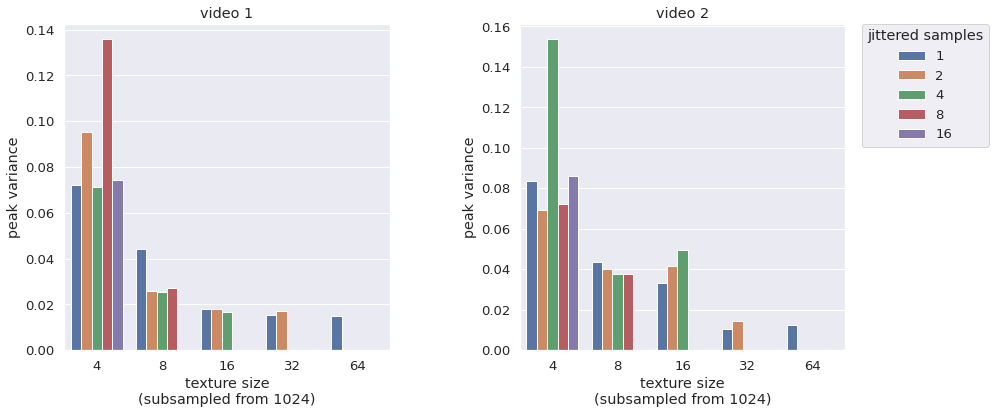

#### Difference

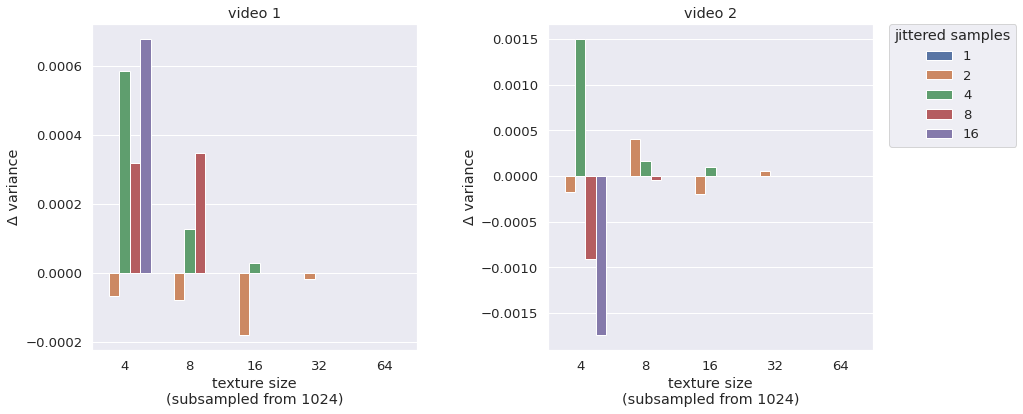

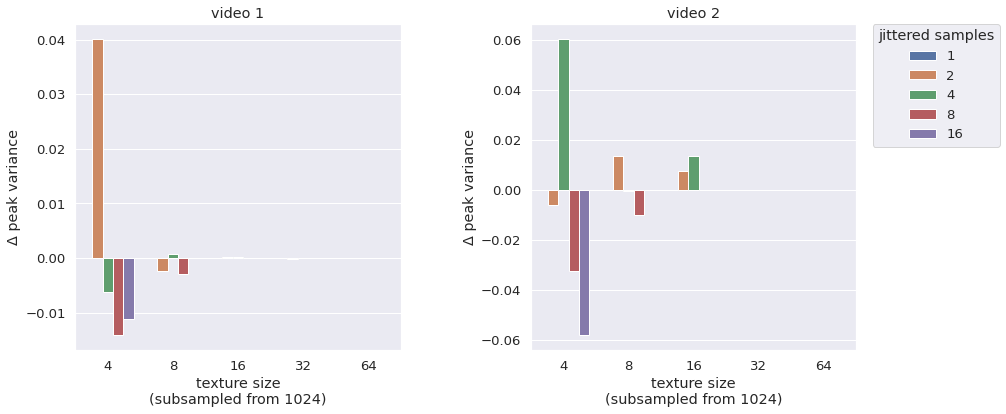


Positive numbers mean variance is greater with scanline jitter.
            

In [12]:
display(Markdown("### Plots"))

def jitter_plots():
    
    def load_video(video_name, measurements):
        return pd.DataFrame(
            [
                (
                    int(measurement["settings"]["texture size"]),
                    measurement["total variance"],
                    measurement["peak variance"],
                    int(measurement["settings"]["jitter size"])
                )
                    for measurement in measurements
                        if measurement["settings"]["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "jitter size"]
        )
    
    def load_video_delta(video_name):
        return pd.DataFrame(
            [
                (
                    int(M4[i]["settings"]["texture size"]),
                    M4[i]["total variance"] - M3[i]["total variance"],
                    M4[i]["peak variance"] - M3[i]["peak variance"],
                    int(M4[i]["settings"]["jitter size"])
                )
                    for i in range(len(M4))
                        if M4[i]["settings"]["video file"] == video_name
            ],
            columns=["texture size", "delta variance", "delta peak variance", "jitter size"]
        )


    data_frames_staggered_jitter = {
        f"video {video}" : load_video(video, M3)
            for video in ["1", "2"]
    }
    
    data_frames_scanline_jitter = {
        f"video {video}" : load_video(video, M4)
            for video in ["1", "2"]
    }
    
    data_frames_delta = {
        f"video {video}" : load_video_delta(video)
            for video in ["1", "2"]
    }

    display(Markdown("#### Staggered jitter"))
    
    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 1"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 2"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 1"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 2"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_variance()
    plot_peak_variance()    
    
    display(Markdown("#### Scanline jitter"))

    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 1"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 2"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 1"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 2"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_variance()
    plot_peak_variance()
    
    display(Markdown("#### Difference"))
    
    def plot_delta_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_delta["video 1"],
            x="texture size",
            y="delta variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("Δ variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_delta["video 2"],
            x="texture size",
            y="delta variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("Δ variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_delta_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_delta["video 1"],
            x="texture size",
            y="delta peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("Δ peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_delta["video 2"],
            x="texture size",
            y="delta peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("Δ peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_delta_variance()
    plot_delta_peak_variance()
    
    display(
        Markdown(
            """
Positive numbers mean variance is greater with scanline jitter.
            """
        )
    )

jitter_plots()

display(
    Markdown(
        """

        """
    )
)

In [10]:
display(Markdown("# Dataset 5: empty cluster randomization"))

M5 = load_measurements("5. empty cluster randomization")

M5 = sorted(
    M5,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["randomize empty clusters"],
    )
)

show_measurements_table(M5)

# Dataset 5: empty cluster randomization

texture size  |  randomize empty clusters  |  video file  |  variance
---------------------------------------------------------------------
512           |  No                        |  1           |  0.00765   
512           |  Yes                       |  1           |  0.00765   
256           |  No                        |  1           |  0.00766   
256           |  Yes                       |  1           |  0.00766   
128           |  No                        |  1           |  0.00765   
128           |  Yes                       |  1           |  0.00765   
64            |  No                        |  1           |  0.00764   
64            |  Yes                       |  1           |  0.00767   
32            |  No                        |  1           |  0.00772   
32            |  Yes                       |  1           |  0.00773   
16            |  No                        |  1           |  0.00827   
16            |  Yes                       |  1           |  0.00824

## Plots

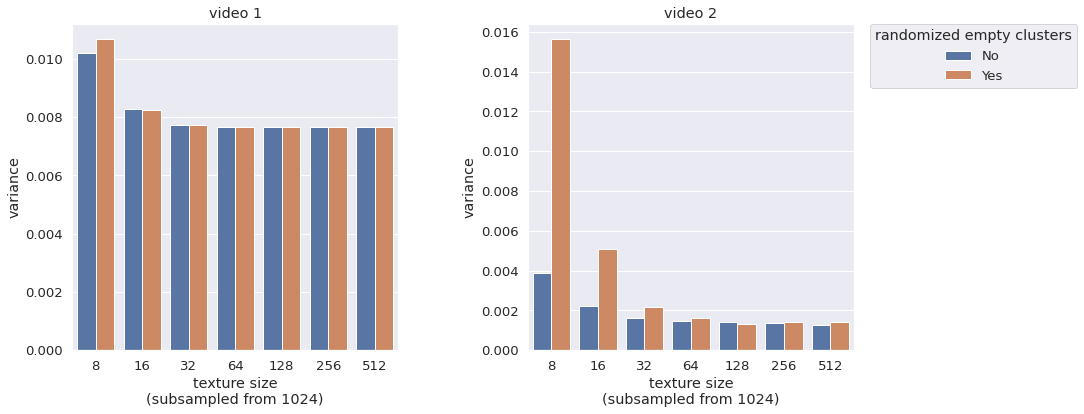

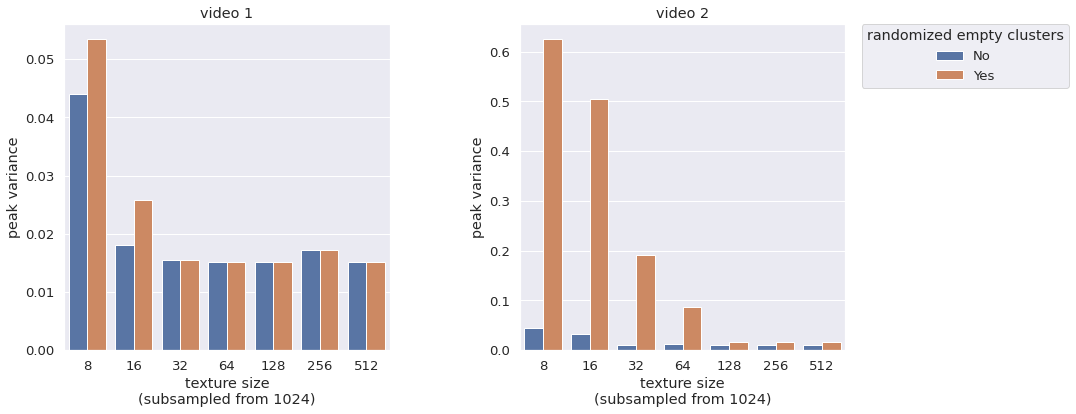

In [14]:
display(Markdown("## Plots"))

def randomized_empty_clusters_plots():

    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement["settings"]["texture size"]),
                    measurement["total variance"],
                    measurement["peak variance"],
                    measurement["settings"]["randomize empty clusters"],
                )
                    for measurement in M5
                        if measurement["settings"]["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "randomized empty clusters"]
        )
    
    data = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    def randomized_empty_clusters_variance_plots():

        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            x=data["video 1"]["texture size"],
            y=data["video 1"]["total variance"],
            ax=axes[0],
            hue=data["video 1"]["randomized empty clusters"],
            ci=None,
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            x=data["video 2"]["texture size"],
            y=data["video 2"]["total variance"],
            ax=axes[1],
            hue=data["video 2"]["randomized empty clusters"],
            ci=None,
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="randomized empty clusters"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()

    def randomized_empty_clusters_peak_variance_plots():

        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            x=data["video 1"]["texture size"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["randomized empty clusters"],
            ci=None,
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            x=data["video 2"]["texture size"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["randomized empty clusters"],
            ci=None,
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="randomized empty clusters"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()

    randomized_empty_clusters_variance_plots()
    randomized_empty_clusters_peak_variance_plots()

randomized_empty_clusters_plots()

In [6]:
display(Markdown("# Dataset 6: KHM and random swap"))

M6 = load_measurements("6. KHM and random swap")

M6 = sorted(
    M6,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        int(measurement["settings"]["number of iterations"]),
        measurement["settings"]["algorithm"],
    )
)

show_measurements_table(M6)

# Dataset 6: KHM and random swap

algorithm  |  number of iterations  |  video file  |  variance
--------------------------------------------------------------
KHM(3)     |  3                     |  1           |  0.00767   
KM         |  3                     |  1           |  0.00764   
RS         |  3                     |  1           |  0.00737   
KHM(3)     |  5                     |  1           |  0.00765   
KM         |  5                     |  1           |  0.00761   
RS         |  5                     |  1           |  0.00733   
KHM(3)     |  7                     |  1           |  0.00764   
KM         |  7                     |  1           |  0.00760   
RS         |  7                     |  1           |  0.00729   
KHM(3)     |  9                     |  1           |  0.00766   
KM         |  9                     |  1           |  0.00759   
RS         |  9                     |  1           |  0.00727   
KHM(3)     |  11                    |  1           |  0.00765   
KM         |  11             

## Plots

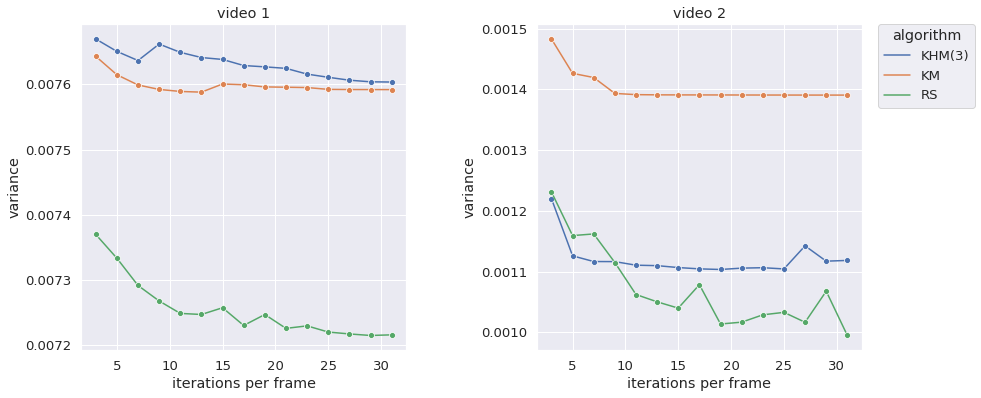

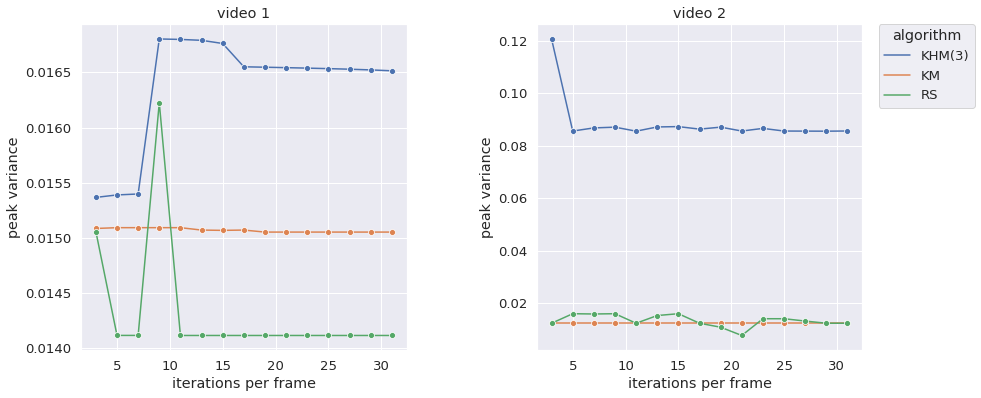


KM overlaps with RS<br>
=> this tells us, that KM never got stuck in a local minimum

## Explanation

KHM converges slower than KM on good initializations.
In this case initialization is good, as demonstrated by RS aligning with KM.

If the initialization was bad, RS would eventually find a better solution than KM.

Slower convergence of KHM causes higher peaks (maybe?).

## Trade-off
* RS and KM have reliably lower peaks than KHM
* KHM is resistant against local minimum with a single iteration
* KM did not get stuck in a local minimum a single time

KHM was implemented with $p=3$ because integer exponent can be optimized by replacing exponentiation with multiplication.
        

In [7]:
display(Markdown("## Plots"))

def algorithms_plot():
    def load_video(video_name, measurements):
        return pd.DataFrame(
            [
                (
                    measurement["settings"]["algorithm"],
                    measurement["total variance"],
                    measurement["peak variance"],
                    int(measurement["settings"]["number of iterations"]),
                )
                    for measurement in measurements
                        if measurement["settings"]["video file"] == video_name
            ],
            columns=["algorithm", "total variance", "peak variance", "number of iterations"]
        )

    data = {
        f"video {video}" : load_video(video, M6)
            for video in ["1", "2"]
    }
    
    def variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["total variance"],
            hue=data["video 1"]["algorithm"],
            ax=axes[0],
            ci=None,
            marker="o",
        )

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("iterations per frame")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["total variance"],
            hue=data["video 2"]["algorithm"],
            ax=axes[1],
            ci=None,
            marker="o",
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("iterations per frame")
        axes[1].set_title("video 2")
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="algorithm"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def peak_variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["algorithm"],
            ci=None,
            marker="o",
        )

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("iterations per frame")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["algorithm"],
            ci=None,
            marker="o",
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("iterations per frame")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="algorithm"
        )

        plt.show()
        
    variance_plot()
    peak_variance_plot()
    
algorithms_plot()

display(
    Markdown(
        """
KM overlaps with RS<br>
=> this tells us, that KM never got stuck in a local minimum

## Explanation

KHM converges slower than KM on good initializations.
In this case initialization is good, as demonstrated by RS aligning with KM.

If the initialization was bad, RS would eventually find a better solution than KM.

Slower convergence of KHM causes higher peaks (maybe?).

## Trade-off
* RS and KM have reliably lower peaks than KHM
* KHM is resistant against local minimum with a single iteration
* KM did not get stuck in a local minimum a single time

KHM was implemented with $p=3$ because integer exponent can be optimized by replacing exponentiation with multiplication.
        """
    )
)

In [17]:
display(
    Markdown(
"""
# PSO

PSO has similar complexity to K-Means, but:
* converges faster
* requires batches of "KM iterations" (batch size = number of particles)

given that we can get away with a single iteration of KM per frame, PSO is not very useful

## Number of clusters

Determining the number of clusters with PSO is a potential significant benefit

### DCPSO

*[2005] Dynamic clustering using particle swarm optimization with
application in image segmentation*

PSO is used to determine optimal ilitialization for ordinary KM, potentionally quite fast.
The best part is that KM code can be left as-is, and PSO initialization built on top of it later.
Leave it for the future work.

But check more recent papers referensing DCPSO.
"""
    )
)


# PSO

PSO has similar complexity to K-Means, but:
* converges faster
* requires batches of "KM iterations" (batch size = number of particles)

given that we can get away with a single iteration of KM per frame, PSO is not very useful

## Number of clusters

Determining the number of clusters with PSO is a potential significant benefit

### DCPSO

*[2005] Dynamic clustering using particle swarm optimization with
application in image segmentation*

PSO is used to determine optimal ilitialization for ordinary KM, potentionally quite fast.
The best part is that KM code can be left as-is, and PSO initialization built on top of it later.
Leave it for the future work.

But check more recent papers referensing DCPSO.


In [18]:
display(Markdown("# KM vs KHM"))

# KM vs KHM

In [8]:
display(Markdown("## KHM(p)"))

def show_KHM_p_measurement():
    Mp = load_measurements(f"KHM(p)")

    Mp = sorted(
        Mp,
        key = lambda measurement: (
            int(measurement["settings"]["video file"]),
        )
    )
    
    show_measurements_table(Mp)
    print("\n")

show_KHM_p_measurement()

## KHM(p)

algorithm  |  video file  |  variance
-------------------------------------
KHM(2)     |  1           |  0.00792   
KHM(3)     |  1           |  0.00767   
KHM(3.5)   |  1           |  0.00850   
KHM(2)     |  2           |  0.00146   
KHM(3)     |  2           |  0.00122   
KHM(3.5)   |  2           |  0.00902   




## Per-frame KM vs KHM

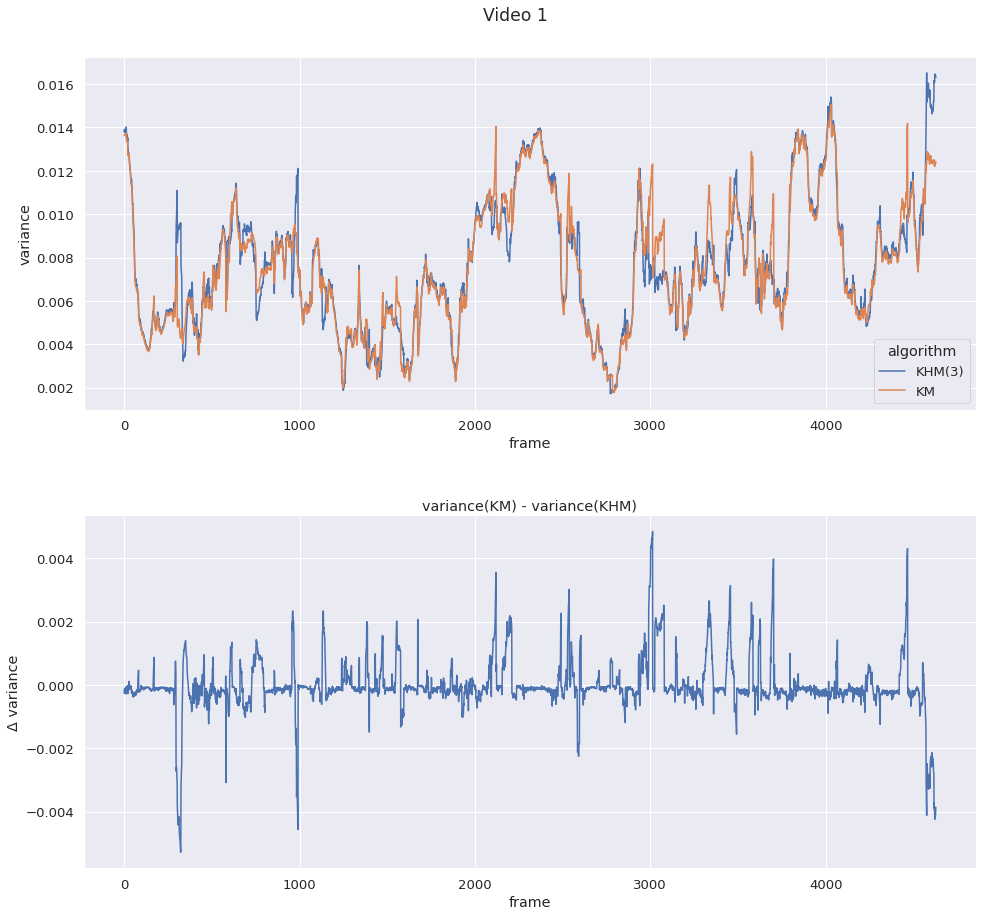

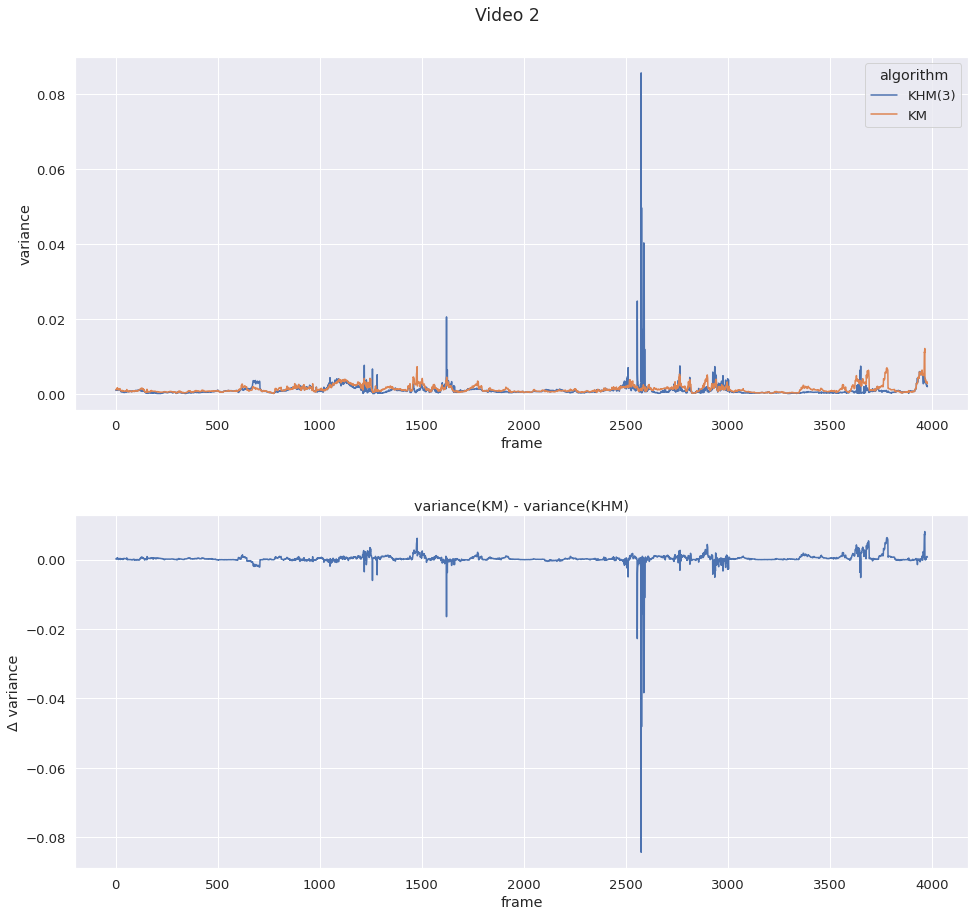

In [9]:
display(Markdown("## Per-frame KM vs KHM"))

def plot_per_frame(video):
    data = pd.DataFrame(
        [
            line
            for measurement_data in [
                list(
                    zip(
                        [algorithm for i in range(len(variances))],
                        [i for i in range(len(variances))],
                        variances
                    )
                )
                for algorithm, variances in [
                    (
                        measurement["settings"]["algorithm"],
                        measurement["variance"]
                    )
                    for measurement in M6
                        if measurement["settings"]["number of iterations"] == "31"
                            and measurement["settings"]["video file"] == video
                            and (
                                measurement["settings"]["algorithm"] != "RS"
                            )
                ]
            ]
            for line in measurement_data
        ],
        columns=["algorithm", "frame", "variance"]
    )
    
    fig, ax = plt.subplots(2,1, figsize=(16,14))
    
    sb.lineplot(
        x=data["frame"],
        y=data["variance"],
        hue=data["algorithm"],
        ci=None,
        ax=ax[0]
    )
    
    #ax[0].set_title("per-frame variance")
    
    data_km = data[data["algorithm"].isin(["KM"])].reset_index()
    data_khm = data[data["algorithm"].isin(["KHM(3)"])].reset_index()
    
    data_diff = data_km.copy()
    del data_diff["algorithm"]
    data_diff["variance"] = [
        data_km.loc[i, "variance"] - data_khm.loc[i, "variance"]
        for i in range(len(data_km["variance"]))
    ]
    
    sb.lineplot(
        x=data_diff["frame"],
        y=data_diff["variance"],
        ci=None,
        ax=ax[1]
    )
    
    ax[1].set_title("variance(KM) - variance(KHM)")
    ax[1].set_ylabel("Δ variance")
    
    fig.suptitle(f"Video {video}")
    
    plt.subplots_adjust(
        hspace=0.3,
        top=0.93
    )
    
    plt.show()
        
plot_per_frame("1")
plot_per_frame("2")

In [10]:
display(Markdown("## Alternate KM-KHM"))

M_alternate = load_measurements("Alternate KM-KHM")

show_measurements_table(M_alternate)

## Alternate KM-KHM

number of iterations  |  video file  |  variance
------------------------------------------------
3                     |  1           |  0.00766   
5                     |  1           |  0.00762   
7                     |  1           |  0.00760   
9                     |  1           |  0.00759   
11                    |  1           |  0.00759   
13                    |  1           |  0.00758   
15                    |  1           |  0.00758   
17                    |  1           |  0.00757   
19                    |  1           |  0.00757   
21                    |  1           |  0.00757   
23                    |  1           |  0.00757   
25                    |  1           |  0.00757   
27                    |  1           |  0.00757   
29                    |  1           |  0.00757   
31                    |  1           |  0.00757   
3                     |  2           |  0.00142   
5                     |  2           |  0.00125   
7                     |  2         

### Plot

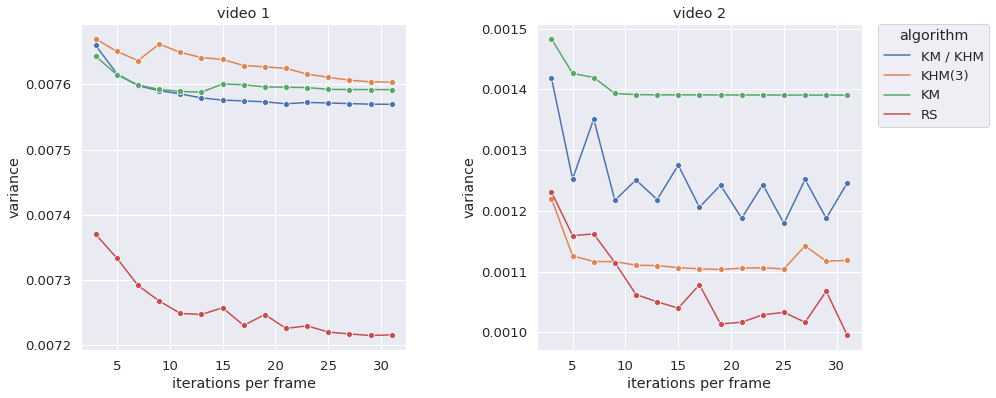

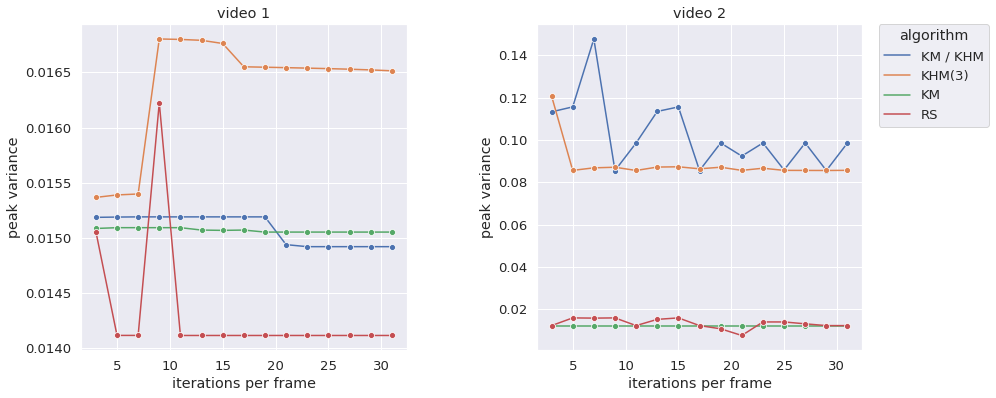


### Compromise

KHM / KM should be enough to avoid local optimum, while reducing downsides of KHM
* slow convergence
* higher peak (mostly due to slow convergence)
        

In [11]:
display(Markdown("### Plot"))

def plot_alternate():

    def load_video(video_name, measurements):
            return pd.DataFrame(
                [
                    (
                        "KM / KHM",
                        measurement["total variance"], # + (0.00001 if measurement["settings"]["random swap"] == "Yes" else 0),
                        measurement["peak variance"],
                        int(measurement["settings"]["number of iterations"]),
                    )
                        for measurement in measurements
                            if measurement["settings"]["video file"] == video_name
                ],
                columns=["algorithm", "total variance", "peak variance", "number of iterations"]
            )

    data = {
        f"video {video}" : load_video(video, M_alternate)
            for video in ["1", "2"]
    }

    for video in data:
        data[video] = pd.concat(
            [
                data[video],
                pd.DataFrame(
                    [
                        (
                            measurement["settings"]["algorithm"],
                            measurement["total variance"],
                            measurement["peak variance"],
                            int(measurement["settings"]["number of iterations"]),
                        )
                            for measurement in M6
                                if measurement["settings"]["video file"] == video.split(" ")[-1]
                                and measurement["settings"]["algorithm"] != "random swap"
                    ],
                    columns=["algorithm", "total variance", "peak variance", "number of iterations"]
                )
            ]
        ).reset_index()
    
    def variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["total variance"],
            hue=data["video 1"]["algorithm"],
            ax=axes[0],
            ci=None,
            marker="o",
        )

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("iterations per frame")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["total variance"],
            hue=data["video 2"]["algorithm"],
            ax=axes[1],
            ci=None,
            marker="o",
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("iterations per frame")
        axes[1].set_title("video 2")
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="algorithm"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def peak_variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["algorithm"],
            ci=None,
            marker="o",
        )

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("iterations per frame")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["algorithm"],
            ci=None,
            marker="o",
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("iterations per frame")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="algorithm"
        )

        plt.show()
        
    variance_plot()
    peak_variance_plot()

plot_alternate()

display(
    Markdown(
        """
### Compromise

KHM / KM should be enough to avoid local optimum, while reducing downsides of KHM
* slow convergence
* higher peak (mostly due to slow convergence)
        """
    )    
)

In [12]:
display(
    Markdown(
        """
### Thoughts

Look at random swap paper to see which prameters affect KM positively and negatively.

* First video has more color variation (overlap), which was observed to improve KM performance.
        """
    )    
)


### Thoughts

Look at random swap paper to see which prameters affect KM positively and negatively.

* First video has more color variation (overlap), which was observed to improve KM performance.
        

## Alternate KM-KHM test

### Initialization

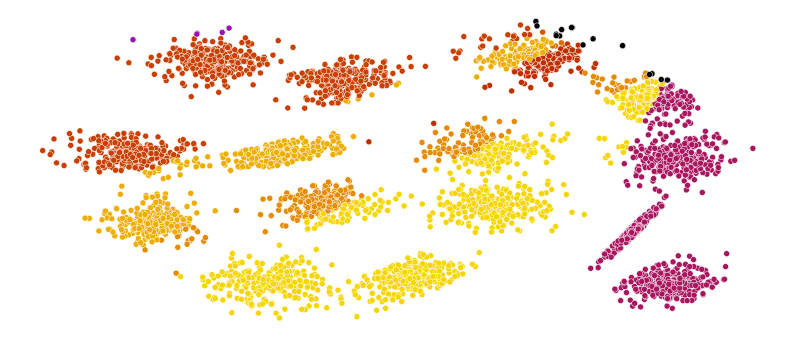

### Algorithms

#### KM

clustering_iterations=60
0... 1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 19... 20... 21... 22... 23... 24... 25... 26... 27... 28... 29... 30... 31... 32... 33... 34... 35... 36... 37... 38... 39... 40... 41... 42... 43... 44... 45... 46... 47... 48... 49... 50... 51... 52... 53... 54... 55... 56... 57... 58... 59... 

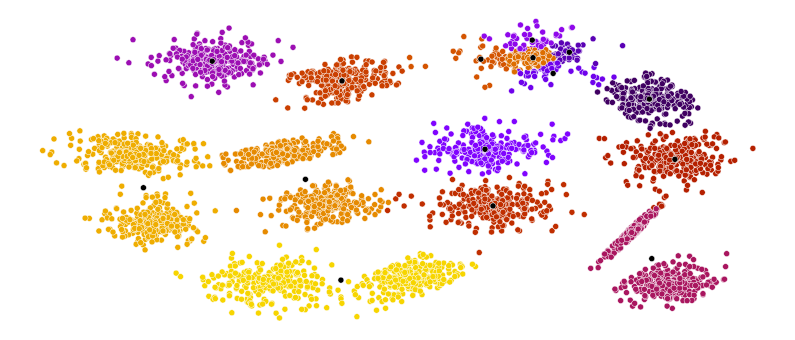

variance: 0.00732146251257129


#### RS

clustering_iterations=30
0... 1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 19... 20... 21... 22... 23... 24... 25... 26... 27... 28... 29... 

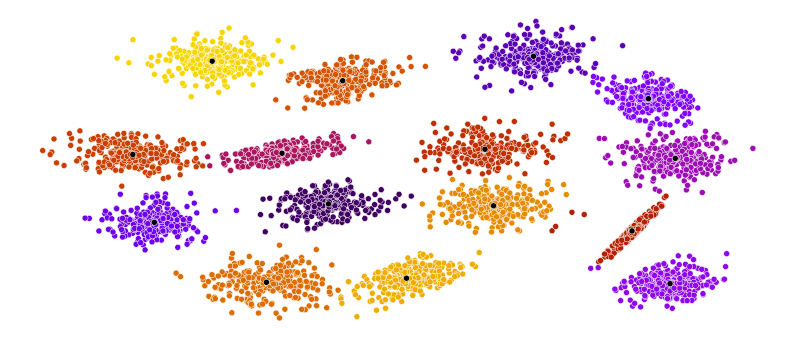

variance: 0.002060533262329585


#### KHM

clustering_iterations=60
0... 1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 19... 20... 21... 22... 23... 24... 25... 26... 27... 28... 29... 30... 31... 32... 33... 34... 35... 36... 37... 38... 39... 40... 41... 42... 43... 44... 45... 46... 47... 48... 49... 50... 51... 52... 53... 54... 55... 56... 57... 58... 59... 

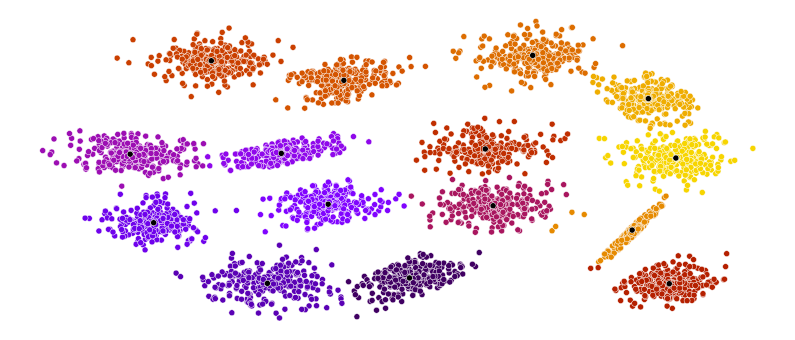

variance: 0.0020623624276435402


#### Alternating

clustering_iterations=60
0... 1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 19... 20... 21... 22... 23... 24... 25... 26... 27... 28... 29... 30... 31... 32... 33... 34... 35... 36... 37... 38... 39... 40... 41... 42... 43... 44... 45... 46... 47... 48... 49... 50... 51... 52... 53... 54... 55... 56... 57... 58... 59... 

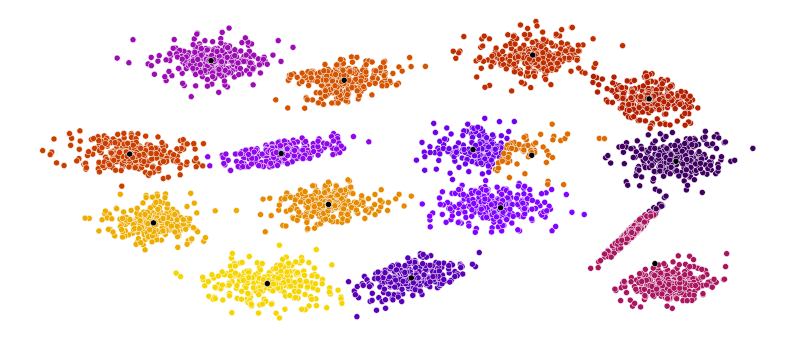

variance: 0.0031440598036417237


#### 1 KM before KHM

clustering_iterations=60
0... 1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 19... 20... 21... 22... 23... 24... 25... 26... 27... 28... 29... 30... 31... 32... 33... 34... 35... 36... 37... 38... 39... 40... 41... 42... 43... 44... 45... 46... 47... 48... 49... 50... 51... 52... 53... 54... 55... 56... 57... 58... 59... 

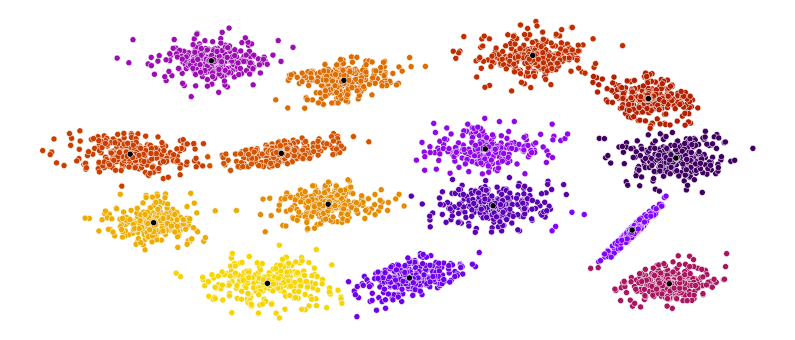

variance: 0.002062362427643543


### Convergence

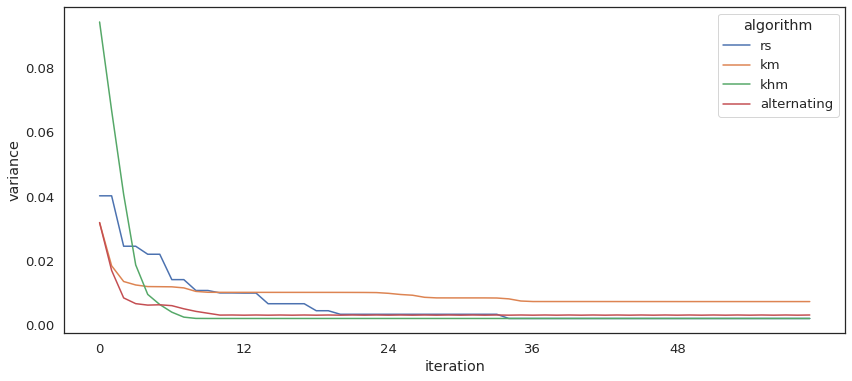

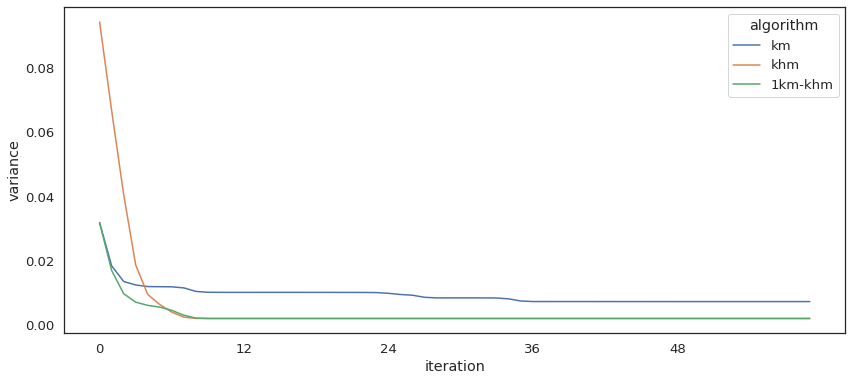


### Conclusion

Alternating KHM/KM is almost as good as KHM, but not quite.

Alternating created 1 misplaced mean (KHM had no misplaced means)
and slightly increased variance, but not nearly as bad as KM alone.

A single KM iteration is enough to eliminate the initial variance spike of KHM
(in this example KHM variance was always lower than KM).
But for the continuous clustering of a video stream there is no "first iteration"
so the next best thing is to alternate KM/KHM.



In [13]:
import random

display(Markdown("## Alternate KM-KHM test"))

def verify_alternating():
    NUM_CLUSTERS = 15
    NUM_ITERATIONS = 60
    
    #with open("Datasets/Birch/Birch1.txt") as file:
    with open("Datasets/S/S1.txt") as file:
        points = [
           filter(
                lambda x: x != "",
                line.split(" ")
            )
            for line in file.readlines()
        ]
        points = [
            tuple([int(coord.replace("/n", "")) for coord in point])
            for point in points
        ]
        
        _ = """
        points = [
            points[random_index]
            for random_index in np.random.choice(
                len(points), 10000, replace=False
            )
        ]
        """
        
        def normalize_points(points):
            transposed_points = list(zip(*points))
            
            min_coords = [
                min(coord_list)
                for coord_list in transposed_points
            ]

            max_coords = [
                max(coord_list)
                for coord_list in transposed_points
            ]

            coords_range = [
                max_coord - min_coord
                for max_coord, min_coord in zip(max_coords, min_coords)
            ]

            def normalize_point(point):
                return [
                    (coord - min_coord) / range_coord
                    for coord, min_coord, range_coord in zip(point, min_coords, coords_range)
                ]
        
            return [
                normalize_point(point)
                for point in points
            ]
        
        points = normalize_points(points)
    
    def init_means(points):               
        return sorted(
            points, 
            key = lambda point: -sum(point)
        )[0:NUM_CLUSTERS]
        
    def distance(point_1, point_2):
        dist = sum(
            [
                (point_1[i] - point_2[i]) ** 2
                for i in range(len(point_1))
            ]
        )
        
        return dist ** 0.5

    def get_attribution(means):
        attribution = [0] * len(points)
        
        def point_mean_index(point):
            distances = [
                distance(
                    point,
                    means[mean_index]
                )
                for mean_index in range(len(means))
            ]
            
            for mean_index in range(len(distances)):
                if distances[mean_index] == min(distances):
                    return mean_index

        return [
            point_mean_index(point)
            for point in points
        ]

        plt.show()
    
    def km_weights(means):
        attribution = get_attribution(means)

        return [
            [
                1
                    if attribution[point_index] == mean_index
                    else
                0
                for mean_index in range(len(means))
            ]
            for point_index in range(len(points))
        ]
    
    def khm_weights(means):
        P = 3
        
        def point_weights(point):
            distances = [
                distance(point, mean)
                for mean in means
            ]

            min_distance = min(distances)
            
            def mean_weight(mean_index):
            
                top = min_distance ** (P - 2)
                if distances[mean_index] != min_distance:
                    top = top * (min_distance / distances[mean_index]) ** (P + 2)

                bot = sum(
                    [
                        (
                            (min_distance / distances[other_mean_index]) ** P
                                if distances[other_mean_index] != min_distance
                                else
                            1
                        )
                        for other_mean_index in range(len(means))
                    ]
                )

                return top / (bot * bot)
            
            return [
                mean_weight(mean_index)
                for mean_index in range(len(means))
           ]
        
        return [
            point_weights(point)
            for point in points
        ]
    
    def update_means(means, weighting_function):

        weights = weighting_function(means)          
        
        return [
            [
                sum(
                    [
                        coord_val * weight
                        for coord_val, weight in zip(coord_vals, cluster_weights)
                    ]
                ) / (
                    sum(
                        cluster_weights
                    )
                )
                for coord_vals in list(zip(*points))
            ]
            for cluster_weights in list(zip(*weights))
        ]
    
    def measure_variance(means):
        def point_variance(point):
            distances = [
                distance(point, mean)
                for mean in means
            ]

            min_distance = min(distances)

            return min_distance * min_distance
        
        point_variances = [
            point_variance(point)
            for point in points
        ]
        
        return sum(point_variances) / len(point_variances)
    
    def print_progress(i):
        print(f"{i}... ", end="")
    
    def show_means(means):        
        g = sb.scatterplot(
            x=list(zip(*points))[0],
            y=list(zip(*points))[1],
            hue=get_attribution(means),
            palette=sb.color_palette(
                "gnuplot", 
                len(
                    set(
                        get_attribution(means)
                    )
                )
            ),
        )
        
        g.set(xticklabels=[])
        g.set(yticklabels=[])
        
        g = sb.scatterplot(
            x=list(zip(*means))[0],
            y=list(zip(*means))[1],
            hue=[-1 for i in range(len(list(zip(*means))[0]))],
            palette=["black"]
        )           
        
        g.legend().remove()
        g.set(xlabel=None)
        
        sb.despine(left=True, bottom=True)
        
        plt.show()
        
    sb.set_style("white")
    
    def run_clustering(algorithm):
        means = init_means(points)
        variances = []
        clustering_iterations = NUM_ITERATIONS
        if algorithm == "rs":
            clustering_iterations //=2
        print(f"{clustering_iterations=}")
        for i in range(clustering_iterations):
            match algorithm:
                case "rs":
                    KM_ITERATIONS = 2
                    cur_variance = measure_variance(means)
                    new_means = means.copy()
                    new_means[random.randrange(len(means))] = random.choice(points)
                    for k in range(KM_ITERATIONS):
                        new_means = update_means(new_means, km_weights)
                    new_variance = measure_variance(new_means)
                    means = new_means if new_variance < cur_variance else means
                    print_progress(i)
                    for k in range(KM_ITERATIONS):
                        variances.append(min(cur_variance, new_variance))
                    continue
                case "km":
                    weighting_function = km_weights
                case "khm":
                    weighting_function = khm_weights
                case "alternating":
                    weighting_function = khm_weights if i % 2 else km_weights
                case "1km-khm":
                    weighting_function = km_weights if i == 0 else khm_weights
                case _ :
                    raise Exception("invalid algorithm")
            means = update_means(means, weighting_function)
            print_progress(i)
            variances.append(measure_variance(means))
        show_means(means)
        print(f"variance: {measure_variance(means)}")
        
        return pd.DataFrame(
            [
                (
                    iteration,
                    variance,
                    algorithm
                )
                    for iteration, variance in enumerate(variances)
            ],
            columns=["iteration", "variance", "algorithm"]
        )
    
    display(Markdown("### Initialization"))
    show_means(init_means(points))
    
    display(Markdown("### Algorithms"))
    
    display(Markdown("#### KM"))
    variances_km = run_clustering("km")
    
    display(Markdown("#### RS"))
    variances_rs = run_clustering("rs")    
    
    display(Markdown("#### KHM"))
    variances_khm = run_clustering("khm")
    
    display(Markdown("#### Alternating"))
    variances_alternating = run_clustering("alternating")
    
    display(Markdown("#### 1 KM before KHM"))
    variances_1km_khm = run_clustering("1km-khm")
    
    display(Markdown("### Convergence"))
    
    variances = pd.concat(
        [
            variances_rs,
            variances_km,
            variances_khm,
            variances_alternating
        ]
    ).reset_index()
    
    sb.lineplot(
        data=variances,
        x="iteration",
        y="variance",
        hue="algorithm",
        ci=None,
        #marker="o",
    )
    
    plt.xticks([x*NUM_ITERATIONS//5 for x in range(5)])
    plt.show()
    
    variances = pd.concat(
        [
            variances_km,
            variances_khm,
            variances_1km_khm
        ]
    ).reset_index()
    
    sb.lineplot(
        data=variances,
        x="iteration",
        y="variance",
        hue="algorithm",
        ci=None,
        #marker="o",
    )
    
    plt.xticks([x*NUM_ITERATIONS//5 for x in range(5)])
    plt.show()
    

#%snakeviz verify_alternating()
verify_alternating()

display(
    Markdown(
"""
### Conclusion

Alternating KHM/KM is almost as good as KHM, but not quite.

Alternating created 1 misplaced mean (KHM had no misplaced means)
and slightly increased variance, but not nearly as bad as KM alone.

A single KM iteration is enough to eliminate the initial variance spike of KHM
(in this example KHM variance was always lower than KM).
But for the continuous clustering of a video stream there is no "first iteration"
so the next best thing is to alternate KM/KHM.

"""
    )
)

In [25]:
display(Markdown("# Dataset 7: Alternating KM/KHM and single KM before KHM"))

M7 = load_measurements("7. alternating and single KM")

M7 = sorted(
    M7,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        int(measurement["settings"]["number of iterations"]),
        measurement["settings"]["algorithm"],
    )
)

show_measurements_table(M7)

# Dataset 7: Alternating KM/KHM and single KM before KHM

number of iterations  |  algorithm  |  video file  |  variance
----------------------------------------------------------------
1                     |  1xKM+KHM(3)  |  1           |  0.00782   
1                     |  KHM(3)       |  1           |  0.00778   
1                     |  KM           |  1           |  0.00782   
1                     |  KM+KHM(3)    |  1           |  0.00792   
2                     |  1xKM+KHM(3)  |  1           |  0.00780   
2                     |  KHM(3)       |  1           |  0.00771   
2                     |  KM           |  1           |  0.00770   
2                     |  KM+KHM(3)    |  1           |  0.00780   
3                     |  1xKM+KHM(3)  |  1           |  0.00762   
3                     |  KHM(3)       |  1           |  0.00767   
3                     |  KM           |  1           |  0.00764   
3                     |  KM+KHM(3)    |  1           |  0.00764   
4                     |  1xKM+KHM(3)  |  1           |  0.00769   
4

## Plots

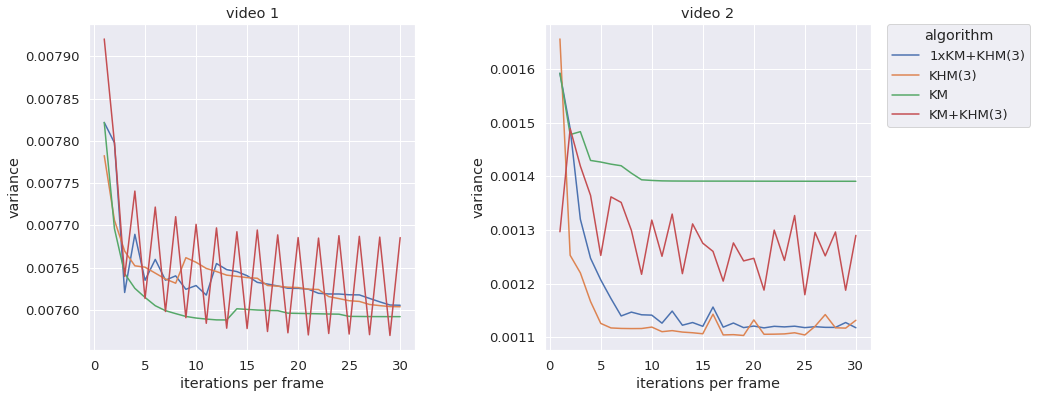

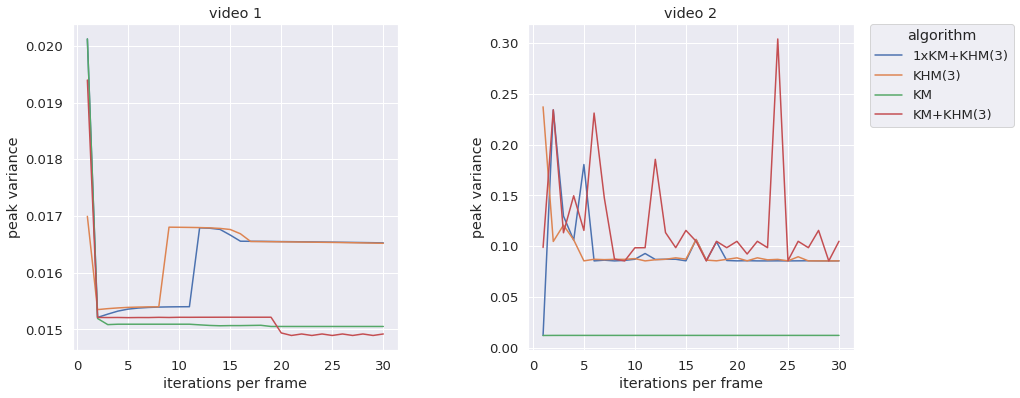

In [26]:
display(Markdown("## Plots"))

sb.set_style("darkgrid")

def algorithms_plot():
    def load_video(video_name, measurements):
        return pd.DataFrame(
            [
                (
                    measurement["settings"]["algorithm"],
                    measurement["total variance"],
                    measurement["peak variance"],
                    int(measurement["settings"]["number of iterations"]),
                )
                    for measurement in measurements
                        if measurement["settings"]["video file"] == video_name
                        and (
                            True
                            #measurement["settings"]["algorithm"] != "KM+KHM(3)"
                            #or int(measurement["settings"]["number of iterations"]) %2 == 1
                        )
            ],
            columns=["algorithm", "total variance", "peak variance", "number of iterations"]
        )

    data = {
        f"video {video}" : load_video(video, M7)
            for video in ["1", "2"]
    }
    
    def variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["total variance"],
            hue=data["video 1"]["algorithm"],
            ax=axes[0],
            ci=None,
            #marker="o",
        )

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("iterations per frame")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["total variance"],
            hue=data["video 2"]["algorithm"],
            ax=axes[1],
            ci=None,
            #marker="o",
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("iterations per frame")
        axes[1].set_title("video 2")
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="algorithm"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def peak_variance_plot():
        _, axes = plt.subplots(1, 2)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["algorithm"],
            ci=None,
            #marker="o",
        )

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("iterations per frame")
        axes[0].set_title("video 1")
        
        g.legend().remove()

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["algorithm"],
            ci=None,
            #marker="o",
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("iterations per frame")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )
        
        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="algorithm"
        )

        plt.show()
        
    variance_plot()
    peak_variance_plot()
    
algorithms_plot()